# Some initial stuff

In [4]:
# -*- coding: utf-8 -*-
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization!
import tensorflow as tf
from LayersRagged import RaggedGravNet, RaggedConstructTensor
import DeepJetCore.DataCollection as dc
from model_overfitting_king import OverfittingKing
from model_overfitting_queen import OverfittingQueen

import os
from object_condensation import evaluate_loss
import uuid
import time
import pickle
from object_condensation import remove_zero_length_elements_from_ragged_tensors
import argparse
import numpy as np


data = dc.DataCollection('/eos/cms/store/cmst3/group/hgcal/CMG_studies/pepr/50_part_sample/testdata/dataCollection.djcdc')
data.setBatchSize(10000)
data.invokeGenerator()
nbatches = data.generator.getNBatches()
print("The data has",nbatches,"batches.")
gen = data.generatorFunction()
batch = xbatch = gen.next()

ragged_constructor = RaggedConstructTensor()


print("Ready")




('The data has', 3995, 'batches.')
Ready


# This will reload the model

Find the training id and put it there and also put the correct model. It will print number of iterations quicky skim through it to see if the correct model is getting loaded.

In [10]:
# Overfitting one
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)


t=2


if t==1:
    my_model = OverfittingKing()
    trainid = '0b7cb6a8ccbc40ba9cf0520ae6eb28c0'
elif t==2:
    my_model = OverfittingQueen()
    trainid = 'ee47b274a1ad4fc996be6f6c4affc74c'
else:
    0/0

print(my_model)

# Non overfitting
# trainid = '5bdeef1e6b0c4bf19ca77b93028978ea'


checkpoints_path = 'train_data/%s/checkpoints' % trainid



checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=my_model)
manager = tf.train.CheckpointManager(
    checkpoint, directory=checkpoints_path, max_to_keep=5)
status = checkpoint.restore(manager.latest_checkpoint)

print("Trained for", optimizer.iterations.numpy(),"iterations")
print(status)

('Trained for', 101, 'iterations')


In [11]:

clustering_space, beta_values = my_model.call(xbatch[0][0], xbatch[0][1])
y_data, row_splits = ragged_constructor((xbatch[1][0], xbatch[1][1]))
y_data = y_data[:, 0]

beta_values = beta_values.numpy()
# print(beta_values[beta_values>0.3])

# print(len(beta_values[beta_values>0.3]))


np.set_printoptions(threshold=np.inf)
# print(repr(np.sort(beta_values)))


# print("Hello wohooo")

sum = 0
for i in range(len(row_splits) - 1):
    x_data_this = y_data[row_splits[i]:row_splits[i+1]].numpy()
    u = np.unique(x_data_this)
#     print(u)
    sum+= len(u)


# print("Unique showers", sum)

In [12]:
def plot_shower(x_data, clustering_space, classes):
    x_data_this_x = x_data[:, 1]
    x_data_this_y = x_data[:, 2]
    x_data_this_z = x_data[:, 7]
    x_data_this_energy = x_data[:, 0]    
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(x_data_this_z, x_data_this_x, x_data_this_y, c = classes, s=x_data_this_energy*10, cmap=plt.get_cmap('Dark2'))
    plt.show()

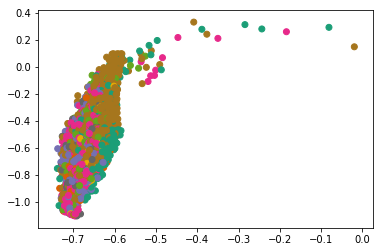

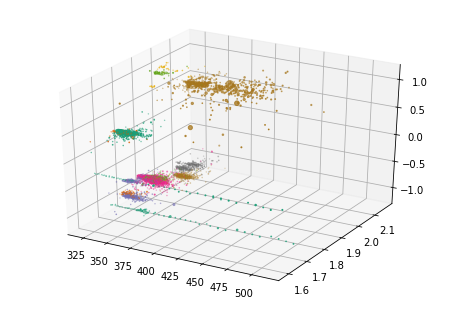

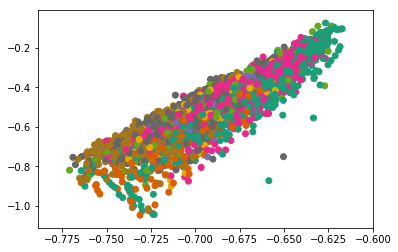

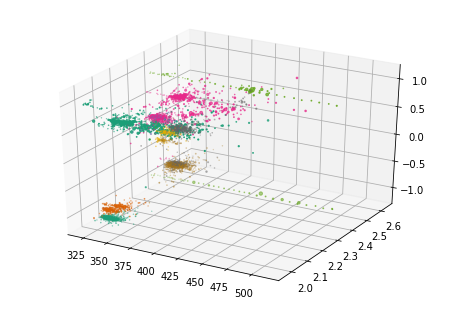

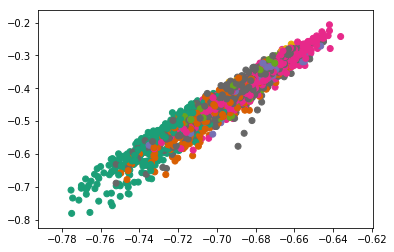

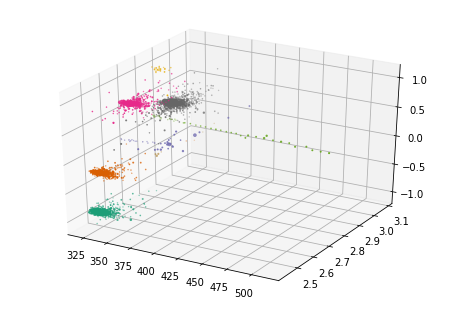

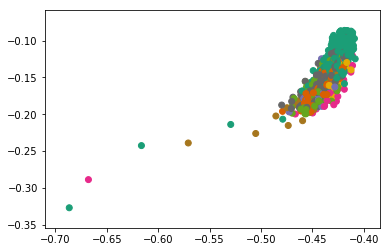

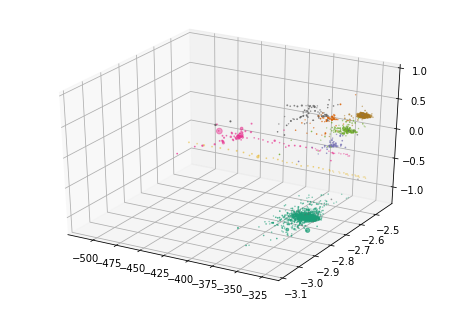

In [13]:

clustering_space, beta_values = my_model.call(xbatch[0][0], xbatch[0][1])



for i in range(4):
    id = i
    this_clustering_space = clustering_space[row_splits[id]:row_splits[id+1]]
    this_classes = y_data[row_splits[id]:row_splits[id+1]]
    this_x = xbatch[0][0][row_splits[id]:row_splits[id+1]]
    
    plt.figure()
    plt.scatter(this_clustering_space[:,0].numpy(), this_clustering_space[:,1].numpy(), c=this_classes.numpy(), cmap=plt.get_cmap('Dark2'))
    plt.show()
    plot_shower(this_x, this_clustering_space, this_classes)
    
    